# Overview

Welcome to the 2018 RSNA Challenge co-hosted by Kaggle. In this competition, the primary endpoint will be the detection of bounding boxes corresponding to the diagnosis of pneumonia (e.g. lung infection) on chest radiographs, a special 2D high resolution grayscale medical image. Note that pnuemonia is just one of many possible disease processes that can occur on a chest radiograph, and that any given single image may contain 0, 1 or many boxes corresponding to possible pneumonia locations.

In [1]:
%load_ext autoreload
# 0: off, 2: on for all modules
%autoreload 2

%load_ext tensorboard

In [1]:
import sys
from src.config import directories
compositional_nets_path = directories['CompositionalNets']
if compositional_nets_path not in sys.path:
    sys.path.append(compositional_nets_path)

In [2]:
import os
import time
import glob, pylab, pandas as pd
import pydicom, numpy as np
import matplotlib.pyplot as plt
import zipfile
import pdb
from tqdm import tqdm, tqdm_notebook
from PIL import Image
import torch
import numpy as np
from torch.utils.data import DataLoader
import torchvision.models as models
from torch import nn
from torchvision import transforms
import cv2
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from Code.losses import ClusterLoss
from Code.config import categories, categories_train, occ_types_vmf, dataset, data_path, device_ids, mix_model_path, dict_dir, layer, vMF_kappa, model_save_dir, compnet_type, backbone_type, num_mixtures
from Code.config import config as cfg
from Code.model import Net
from Code.helpers import Imgset, getVmfKernels, getCompositionModel, update_clutter_model
from Code.eval_occlusion_localization import visualize_response_map

DATA_PATH = directories['data']
MODELS_PATH = os.path.join(directories['CompositionalNets'], 'models')
data_archive_filepath = os.path.join(DATA_PATH, 'rsna-pneumonia-detection-challenge.zip')
dataset_path = os.path.join(DATA_PATH, 'rsna-pneumonia-detection-challenge')

# Challenge Data

The several key items in this folder:
* `stage_2_train_labels.csv`: CSV file containing training set patientIds and  labels (including bounding boxes)
* `stage_2_detailed_class_info.csv`: CSV file containing detailed labels (explored further below)
* `stage_2_train_images/`:  directory containing training set raw image (DICOM) files

In [6]:
df = pd.read_csv(os.path.join(dataset_path, 'stage_2_train_labels.csv'))
# df.head()
df_detailed = pd.read_csv(os.path.join(dataset_path, 'stage_2_detailed_class_info.csv'))
# df_detailed.head()
df['class'] = df_detailed['class']

# Exploring the Data and Labels

As alluded to above, any given patient may potentially have many boxes if there are several different suspicious areas of pneumonia. To collapse the current CSV file dataframe into a dictionary with unique entries, consider the following method:

In [7]:
def parse_data(df, dataset_path):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': os.path.join(dataset_path, f'stage_2_train_images/{pid}.dcm'),
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

parsed = parse_data(df, dataset_path)

# Visualizing Boxes

In order to overlay color boxes on the original grayscale DICOM files, consider using the following  methods (below, the main method `draw()` requires the method `overlay_box()`):

In [8]:
def draw(dicom_path, boxes, plot=False):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(dicom_path)
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in boxes:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)
    
    if plot:
        plt.imshow(im, cmap='gray')
#     pylab.imshow(im, cmap=pylab.cm.gist_gray)
#     pylab.axis('off')
    return im


def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

# Experiments

In [9]:
class ImageSet(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None, do_resize=True, is_square=True):
        super(ImageSet, self).__init__()
        self.images = images
        self.labels = labels
        self.transform = transform
#         self.loader = loader
        self.do_resize = do_resize
#         self.is_square = is_square

    def __getitem__(self, index):
        preloaded_image = self.images[index]
        
        # CompositionalNet takes RGB images as input
        input_image = Image.fromarray(preloaded_image)
#         if input_image.mode != 'RGB': input_image = input_image.convert('RGB')
        
        if self.transform:
            preprocess = self.transform
        else:
            if self.do_resize:
                preprocess =  transforms.Compose([
                    transforms.Grayscale(3),
                    transforms.Resize((224, 224)),
                    transforms.ToTensor()
                ])
            else:
                preprocess =  transforms.Compose([
                    transforms.Grayscale(3),
                    transforms.ToTensor()
                ])
            
        image = preprocess(input_image)
        label = self.labels[index]
        return image, label

    def __len__(self):
        return len(self.images)

In [11]:
def load_images(df, dataset_path, label, mode='train', num_images=None):
    images = []
    if num_images is not None:
        patientIds = df[df['class'] == label]['patientId'].values[:num_images]
    else:
        patientIds = df[df['class'] == label]['patientId'].values
    for patientId in patientIds:
        path = os.path.join(dataset_path, f'stage_2_{mode}_images', f'{patientId}.dcm')
        d = pydicom.read_file(path)
        im = d.pixel_array
        images.append(im)
    return images

In [12]:
%%time
num_images = 1000
X_normal = load_images(df, dataset_path, 'Normal', num_images=num_images)
X_sick = load_images(df, dataset_path, 'Lung Opacity', num_images=num_images)

CPU times: user 16.3 s, sys: 5.24 s, total: 21.5 s
Wall time: 1min 2s


In [13]:
# im = Image.fromarray(X_normal[1])
# if im.mode != 'RGB': im = im.convert('RGB')
# im.save('background_images/xray_general.JPEG')
# Image.fromarray(X_sick[0]).convert('RGB').save('background_images/xray_pneumonia.JPEG')

In [7]:
def init_model(likely = 0.6,
    vc_flag = True,
    mix_flag = True,
    bool_mixture_model_bg = True,
    bool_load_pretrained_model = True,
    occ_types=['general', 'pneumonia']):

    if backbone_type=='vgg':
        if layer=='pool4':
            extractor = models.vgg16(pretrained=True).features[0:24]
        else:
            extractor = models.vgg16(pretrained=True).features
    elif backbone_type=='resnet50' or backbone_type=='resnext':
        extractor = resnet_feature_extractor(backbone_type, layer)

    if device_ids:
        extractor.cuda(device_ids[0]).eval()
    else:
        extractor.eval()
    weights = getVmfKernels(dict_dir, device_ids)

    if bool_load_pretrained_model:
        pretrained_file = 'models/'+'vgg_pool5_p3d+/best.pth'
    else:
        pretrained_file = ''

    occ_likely = []
    for i in range(len(categories_train)):
        # setting the same occlusion likelihood for all classes
        occ_likely.append(likely)

    # load the CompNet initialized with ML and spectral clustering
    mix_models = getCompositionModel(device_ids,mix_model_path,layer,
                                     categories_train,compnet_type=compnet_type)
#     pdb.set_trace()
    net = Net(extractor, weights, vMF_kappa, occ_likely, mix_models, 
              bool_mixture_bg=bool_mixture_model_bg,compnet_type=compnet_type,
              num_mixtures=num_mixtures, vc_thresholds=cfg.MODEL.VC_THRESHOLD,
             occ_types=occ_types)

    if bool_load_pretrained_model:
        if device_ids:
            net.load_state_dict(torch.load(pretrained_file, 
                                           map_location='cuda:{}'.format(device_ids[0]))['state_dict'])
            print('Pretrained model loaded')
        else:
            net.load_state_dict(torch.load(pretrained_file, 
                                   map_location='cpu')['state_dict'])
            print('Pretrained model loaded')
            
    if device_ids:
        net = net.cuda(device_ids[0])
        
    return net

In [8]:
def train(model, train_data, val_data=None, epochs=5, batch_size=1, learning_rate=1e-2,
    alpha = 3, beta = 3, likely = 0.6, vc_flag = True, mix_flag = True, bool_mixture_model_bg = True, 
    bool_load_pretrained_model = True, bool_train_with_occluders = False, 
    occ_types=['general', 'pneumonia']):

    if bool_train_with_occluders:
        writer = SummaryWriter('runs/rsna/with_occluders')
    else:
        writer = SummaryWriter('runs/rsna/without_occluders')
    
    model_save_dir = 'models/rsna'
    savedir = os.path.join(model_save_dir, 
                           f'alpha_{alpha}_beta_{beta}_likely_{likely}_vc_{vc_flag}_mix_{mix_flag}_epochs_{epochs}')
    
    best_check = {
        'epoch': 0,
        'best': 0,
        'val_acc': 0
    }
    out_file_name = savedir + 'result.txt'
    total_train = len(train_data)
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    for param in model.backbone.parameters():
        param.requires_grad = False

    if not vc_flag:
        model.conv1o1.weight.requires_grad = False
    else:
        model.conv1o1.weight.requires_grad = True

    if not mix_flag:
        model.mix_model.requires_grad = False
    else:
        model.mix_model.requires_grad = True

    classification_loss = nn.CrossEntropyLoss()
    cluster_loss = ClusterLoss()

    optimizer = torch.optim.Adagrad(params=filter(lambda param: param.requires_grad, 
                                                  model.parameters()), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.98)

    print('Training')

    for epoch in range(epochs):
        out_file = open(out_file_name, 'a')
        train_loss = 0.0
        correct = 0
        start = time.time()
        model.train()
        model.backbone.eval()

        for index, data in enumerate(train_loader):
            if index % 500 == 0 and index != 0:
                end = time.time()
                print('Epoch{}: {}/{}, Acc: {}, Loss: {} Time:{}'.format(epoch + 1, index, 
                                                                         total_train, 
                                                                         correct.cpu().item() / index, train_loss.cpu().item() / index, 
                                                                         (end-start)))
                start = time.time()
            if len(data) == 2:
                input, label = data
            elif len(data) == 3:
                input, mask, label = data

            if device_ids:
                input = input.cuda(device_ids[0])
                label = label.cuda(device_ids[0])

            output, vgg_feat, like = model(input)

#             pdb.set_trace()
            out = output.argmax(1)
            correct += torch.sum(out == label)
            class_loss = classification_loss(output, label) / output.shape[0]

            loss = class_loss
            if alpha != 0:
                clust_loss = cluster_loss(vgg_feat, model.conv1o1.weight) / output.shape[0]
                loss += alpha * clust_loss

            if beta!=0:
                mix_loss = like[0,label[0]]
                loss += -beta *mix_loss

            #with torch.autograd.set_detect_anomaly(True):
            loss.backward()

            # pseudo batches
            if np.mod(index,batch_size)==0:# and index!=0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.detach() * input.shape[0]

        updated_clutter = update_clutter_model(model,device_ids, occ_types)
        model.clutter_model = updated_clutter
        scheduler.step()
        train_acc = correct.cpu().item() / total_train
        train_loss = train_loss.cpu().item() / total_train
        out_str = 'Epochs: [{}/{}], Train Acc:{}, Train Loss:{}'.format(epoch + 1, 
                                                                        epochs, train_acc, train_loss)
        writer.add_scalar('training loss', train_loss, epoch+1)
        print(out_str)
        
    return model

# Sanity Check

In [4]:
def getImg(archive, mode, categories, dataset, data_path, 
           cat_test=None, occ_level='ZERO', occ_type=None, bool_load_occ_mask = False):
    dataset="pascal3d+"
    if mode == 'train':
        train_imgs = []
        train_labels = []
        train_masks = []
        for category in categories:
#             pdb.set_trace()
            if dataset == 'pascal3d+':
#                 if occ_level == 'ZERO':
                filelist = 'pascal3d+_occ/' + category + '_imagenet_train' + '.txt'
                img_dir = 'pascal3d+_occ/TRAINING_DATA/' + category + '_imagenet'
            elif dataset == 'coco':
#                 if occ_level == 'ZERO':
                img_dir = 'coco_occ/{}_zero'.format(category)
                filelist = 'coco_occ/{}_{}_train.txt'.format(category, occ_level)

            with archive.open(filelist, 'r') as fh:
                contents = fh.readlines()
            img_list = [cc.strip().decode('ascii') for cc in contents]
            label = categories.index(category)
            for img_path in img_list:
                if dataset=='coco':
                    if occ_level == 'ZERO':
                        img = img_dir + '/' + img_path + '.jpg'
                    else:
                        img = img_dir + '/' + img_path + '.JPEG'
                else:
                    img = img_dir + '/' + img_path + '.JPEG'
                occ_img1 = []
                occ_img2 = []
                train_imgs.append(img)
                train_labels.append(label)
                train_masks.append([occ_img1,occ_img2])
        
        return train_imgs, train_labels, train_masks

    else:
        test_imgs = []
        test_labels = []
        occ_imgs = []
        for category in cat_test:
            if dataset == 'pascal3d+':
                filelist = data_path + 'pascal3d+_occ/' + category + '_imagenet_occ.txt'
                img_dir = data_path + 'pascal3d+_occ/' + category + 'LEVEL' + occ_level
                if bool_load_occ_mask:
                    if  occ_type=='':
                        occ_mask_dir = 'pascal3d+_occ/' + category + 'LEVEL' + occ_level+'_mask_object'
                    else:
                        occ_mask_dir = 'pascal3d+_occ/' + category + 'LEVEL' + occ_level+'_mask'
                    occ_mask_dir_obj = 'pascal3d+_occ/0_old_masks/'+category+'_imagenet_occludee_mask/'
            elif dataset == 'coco':
                if occ_level == 'ZERO':
                    img_dir = 'coco_occ/{}_zero'.format(category)
                    filelist = 'coco_occ/{}_{}_test.txt'.format(category, occ_level)
                else:
                    img_dir = 'coco_occ/{}_occ'.format(category)
                    filelist = 'coco_occ/{}_{}.txt'.format(category, occ_level)

#             if os.path.exists(filelist):
            with archive.open(filelist, 'r') as fh:
                contents = fh.readlines()
            img_list = [cc.strip().decode('ascii') for cc in contents]
            label = categories.index(category)
            for img_path in img_list:
                if dataset != 'coco':
                    if occ_level=='ZERO':
                        img = img_dir + occ_type + '/' + img_path[:-2] + '.JPEG'
                        occ_img1 = []
                        occ_img2 = []
                    else:
                        img = img_dir + occ_type + '/' + img_path + '.JPEG'
                        if bool_load_occ_mask:
                            occ_img1 = occ_mask_dir + '/' + img_path + '.JPEG'
                            occ_img2 = occ_mask_dir_obj + '/' + img_path + '.png'
                        else:
                            occ_img1 = []
                            occ_img2 = []

                else:
                    img = img_dir + occ_type + '/' + img_path + '.jpg'
                    occ_img1 = []
                    occ_img2 = []

                test_imgs.append(img)
                test_labels.append(label)
                occ_imgs.append([occ_img1,occ_img2])
#             else:
#                 print('FILELIST NOT FOUND: {}'.format(filelist))
        return test_imgs, test_labels, occ_imgs


def imgLoader(archive, img_path,mask_path,
              bool_resize_images=True,bool_square_images=False):
    
    archive_img_path = archive.open(img_path)
    input_image = Image.open(archive_img_path)
    if bool_resize_images:
        if bool_square_images:
            input_image.resize((224,224),Image.ANTIALIAS)
        else:
            sz=input_image.size
            min_size = np.min(sz)
            if min_size!=224:
                input_image = input_image.resize((np.asarray(sz) * (224 / min_size)).astype(int),Image.ANTIALIAS)
    preprocess =  transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
    )
    img = preprocess(input_image)

    if mask_path[0]:
        mask1 = cv2.imread(mask_path[0])
        if mask1:
            mask1 = mask1[:, :, 0]
            mask1 = myresize(mask1, 224, 'short')
        else:
            mask = np.ones((img.shape[0], img.shape[1])) * 255.0
        try:
            mask2 = cv2.imread(mask_path[1])[:, :, 0]
            mask2 = mask2[:mask1.shape[0], :mask1.shape[1]]
        except:
            mask = mask1
        try:
            mask = ((mask1 == 255) * (mask2 == 255)).astype(np.float)
        except:
            mask = mask1
    else:
        mask = np.ones((img.shape[0], img.shape[1])) * 255.0

    mask = torch.from_numpy(mask)
    return img,mask


class Imgset():
    def __init__(self, archive, imgs, masks, labels, loader,bool_square_images=False):
        self.archive = archive
        self.images = imgs
        self.masks 	= masks
        self.labels = labels
        self.loader = loader
        self.bool_square_images = bool_square_images

    def __getitem__(self, index):
        fn = self.images[index]
        label = self.labels[index]
        mask = self.masks[index]
        img,mask = self.loader(self.archive,fn,mask,bool_resize_images=True,bool_square_images=self.bool_square_images)
        return img, mask, label

    def __len__(self):
        return len(self.images)

def save_checkpoint(state, filename, is_best):
    if is_best:
        print("=> Saving new checkpoint")
        torch.save(state, filename)
    else:
        print("=> Validation Accuracy did not improve")

In [5]:
from Code.config import categories, categories_train, dataset
import random
bool_train_with_occluders = False
train_imgs=[]
train_masks = []
train_labels = []
val_imgs = []
val_labels = []
val_masks=[]
zipfile_fp = os.path.join(DATA_PATH, 'CompNet_data.zip')
archive = zipfile.ZipFile(zipfile_fp)
occ_levels_train = ['_white', '_noise', 'general']
# get training and validation images
for occ_level in occ_levels_train:
    if occ_level == 'ZERO':
        occ_types = ['']
        train_fac=0.9
    else:
        occ_types = ['_white', '_noise', '_texture', '']
        train_fac=0.1

    for occ_type in occ_types:
        imgs, labels, masks = getImg(archive, 'train', categories_train, dataset, data_path, 
                                     categories, occ_level, occ_type, bool_load_occ_mask=False)
        nimgs=len(imgs)
        for i in range(nimgs):
            if (random.randint(0, nimgs - 1) / nimgs) <= train_fac:
                train_imgs.append(imgs[i])
                train_labels.append(labels[i])
                train_masks.append(masks[i])
            elif not bool_train_with_occluders:
                val_imgs.append(imgs[i])
                val_labels.append(labels[i])
                val_masks.append(masks[i])

print('Total imgs for train ' + str(len(train_imgs)))
print('Total imgs for val ' + str(len(val_imgs)))
train_imgset = Imgset(archive, train_imgs,train_masks, train_labels, imgLoader,bool_square_images=False)

val_imgsets = []
if val_imgs:
    val_imgset = Imgset(archive, val_imgs,val_masks, val_labels, imgLoader,bool_square_images=False)
    val_imgsets.append(val_imgset)

Total imgs for train 13277
Total imgs for val 119251


In [10]:
model = init_model(occ_types=['_white', '_noise'])

Pretrained model loaded


In [11]:
model = train(model, train_imgset, epochs=30)

Training
Epoch1: 500/13277, Acc: 0.982, Loss: -42.00629296875 Time:31.847212314605713
Epoch1: 1000/13277, Acc: 0.981, Loss: -42.4415 Time:28.474977254867554
Epoch1: 1500/13277, Acc: 0.98, Loss: -42.414734375 Time:28.298557996749878


KeyboardInterrupt: 

In [253]:
# torch.save(model.state_dict(), 'results/reproduce/1.pth')

In [9]:
model.load_state_dict(torch.load('results/reproduce/1.pth'))

<All keys matched successfully>

In [21]:
occ_levels = ['ZERO', 'ONE', 'FIVE', 'NINE']
# test_loader = DataLoader(dataset=val_imgset, batch_size=1, shuffle=False)
test_images = []
test_labels = []
test_masks = []
for occ_level in occ_levels:

    if occ_level == 'ZERO':
        occ_types = ['']
    else:
        if dataset=='pascal3d+':
            occ_types = ['_white','_noise', '_texture', '']
        elif dataset=='coco':
            occ_types = ['']

    for index, occ_type in enumerate(occ_types):
        # load images
        images, labels, masks = getImg(archive, 'test', categories_train, dataset, '', 
                                     categories, occ_level, occ_type, bool_load_occ_mask=True)
        test_images.extend(images)
        test_labels.extend(labels)
        test_masks.extend(masks)
        
test_imgset = Imgset(archive, test_images, test_masks, test_labels, imgLoader, bool_square_images=False)
test_loader = DataLoader(dataset=test_imgset, batch_size=1, shuffle=False)




0it [00:00, ?it/s]


1it [00:01,  1.75s/it]


2it [00:02,  1.39s/it]


3it [00:02,  1.03s/it]


4it [00:02,  1.17it/s]


5it [00:18,  5.32s/it]


6it [00:19,  3.84s/it]


7it [00:19,  2.85s/it]


8it [00:20,  2.15s/it]


9it [00:20,  1.62s/it]


10it [00:20,  1.24s/it]


11it [00:21,  1.00s/it]


12it [00:21,  1.16it/s]


13it [00:22,  1.49it/s]


14it [00:22,  1.90it/s]


15it [00:22,  2.18it/s]


16it [00:22,  2.32it/s]


17it [00:23,  2.39it/s]


18it [00:23,  2.44it/s]


19it [00:24,  2.57it/s]


20it [00:24,  2.73it/s]


21it [00:24,  3.20it/s]


22it [00:24,  3.14it/s]


23it [00:25,  2.80it/s]


24it [00:25,  2.56it/s]


25it [00:25,  3.06it/s]


26it [00:26,  3.46it/s]


27it [00:26,  3.85it/s]


28it [00:26,  3.33it/s]


29it [00:27,  2.68it/s]


30it [00:27,  2.77it/s]


31it [00:27,  2.78it/s]


32it [00:28,  2.51it/s]


33it [00:28,  3.01it/s]


34it [00:29,  2.58it/s]


35it [00:29,  2.56it/s]


36it [00:29,  2.68it/s]


37it [00:30,  2.64it/s]


38it [00:30,  2.64it/s]

TypeError: expected np.ndarray (got NoneType)

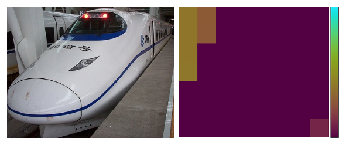

In [23]:
model.eval()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
last_idx = -1

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader)):
        input_img, mask, label = data
        if device_ids:
            input_img = input_img.cuda(device_ids[0])
#         c_label = label.numpy()
        
#         output, *_ = model(input_img)
#         out = output.cpu().numpy().argmax(-1)[0]
#         results.append(out)
#         pred_class = categories_train[out]
#         print('\nImage {} classified as {}'.format(img_name,pred_class))
        #localize occluder
    
        score, occ_maps, part_scores = model.get_occlusion(input_img, label)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='',cbarmax=10, show=False)
        
        # concatenate original image and occluder map
        img_orig = np.array(Image.open(archive.open(test_images[i])))
#         img_orig = np.array(input_img.squeeze().cpu().permute(1, 2, 0))
#         img_orig = img_orig * std + mean
#         img_orig = (255*(img_orig - np.min(img_orig))/np.ptp(img_orig).astype(int)).astype('uint8')
#         faco = img_orig.shape[0] / occ_img.shape[0]
#         occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        occ_img_s = Image.fromarray(occ_img).resize((img_orig.shape[1], img_orig.shape[0]))
#         occ_img_s = cv2.resize(occ_img, (img_orig.shape[1], img_orig.shape[0]))
#         occ_img_s = np.array(transforms.ToTensor()(occ_img_s).permute(1, 2, 0)) * std + mean
#         occ_img_s = occ_img_s.astype('float64')
#         occ_img_s = (occ_img_s - np.min(occ_img_s))/np.ptp(occ_img_s)
        out_name = f'results/reproduce/without_occluder/{i:04d}.png'
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
#         Image.fromarray(canvas).save(out_name)
#         cv2.imwrite(out_name, canvas)
        plt.imshow(canvas)
        plt.axis('off')
        plt.imsave(out_name, canvas)
        
        if i == last_idx: break
# print(f'Accuracy: {accuracy_score(test_labels, results)}')

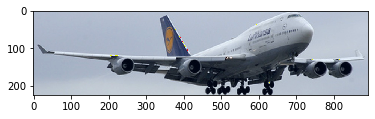

In [23]:
img_orig = input_img.squeeze().cpu().permute(1,2,0).numpy()
# Normalised [0,255] as integer
img_orig = (255*(img_orig - np.min(img_orig))/np.ptp(img_orig).astype(int)).astype('uint8')
plt.imshow(img_orig)

In [218]:
arr = np.array(input_img.squeeze().permute(1, 2, 0).cpu())
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
arr = arr * std + mean
# arr = arr + mean
# plt.imshow(arr)
# Normalised [0,255] as integer
c = 255*(arr - np.min(arr))/np.ptp(arr).astype(int)
c.astype('uint8')

array([[[229, 230, 232],
        [231, 232, 235],
        [231, 232, 235],
        ...,
        [230, 232, 236],
        [230, 230, 232],
        [230, 230, 232]],

       [[230, 232, 234],
        [231, 232, 235],
        [230, 232, 234],
        ...,
        [230, 230, 235],
        [230, 230, 232],
        [230, 230, 232]],

       [[231, 232, 235],
        [230, 232, 234],
        [230, 230, 232],
        ...,
        [230, 232, 236],
        [230, 230, 232],
        [230, 230, 232]],

       ...,

       [[223, 224, 226],
        [224, 225, 228],
        [225, 227, 229],
        ...,
        [168, 179, 183],
        [168, 179, 185],
        [168, 179, 185]],

       [[223, 224, 227],
        [223, 224, 227],
        [223, 224, 227],
        ...,
        [169, 178, 183],
        [167, 178, 184],
        [167, 178, 184]],

       [[225, 227, 229],
        [223, 224, 226],
        [223, 224, 226],
        ...,
        [168, 177, 182],
        [164, 175, 181],
        [164, 175, 181]]

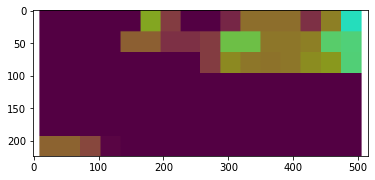

In [221]:
occ_img_s = occ_img_s.astype('float64')
b = (occ_img_s - np.min(occ_img_s))/np.ptp(occ_img_s)

# Without Occluder in Training

## Training

In [5]:
preprocess = transforms.Compose([
    transforms.Grayscale(3),
#     transforms.ColorJitter(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(5),
#     transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.Lambda(lambda x: x * 255)
])

In [32]:
split_idx_normal = int(len(X_normal) * 0.80)
split_idx_sick = int(len(X_sick) * 0.80)

X_train = X_normal[:split_idx_normal]
y_train = [0] * len(X_normal[:split_idx_normal])

X_mask_paths = [[]] * len(X_train)

print('Total images for training ' + str(len(X_train)))
train_imageset = ImageSet(X_train, y_train, transform=preprocess)
# train_imageset = ImageSet(X_train, y_train)
# net = train(X_train, [[]] * len(X_train), y_train, epochs=30, occ_types=['general', 'pneumonia'])

Total images for training 800


In [33]:
%%time
net = init_model(bool_load_pretrained_model=False,occ_types=['general', 'pneumonia'])
net = train(net, train_imageset, epochs=1, bool_train_with_occluders=False)

Training
Epoch1: 500/800, Acc: 0.958, Loss: -53.667375 Time:62.632080078125
Epochs: [1/1], Train Acc:0.97125, Train Loss:-54.5269189453125
CPU times: user 1min 16s, sys: 28.3 s, total: 1min 44s
Wall time: 1min 46s


In [19]:
torch.save(net.state_dict(), 'models/rsna/without_occluders/1.pth')

## Testing

In [34]:
parsed_sick = {k: v for k, v in parsed.items() if v["label"] == 1}





0it [00:00, ?it/s]



1it [00:00,  1.70it/s]



2it [00:00,  1.89it/s]



3it [00:01,  2.17it/s]



4it [00:01,  2.11it/s]



5it [00:02,  2.11it/s]



6it [00:02,  2.18it/s]



7it [00:02,  2.42it/s]



8it [00:03,  2.59it/s]



9it [00:03,  2.64it/s]



10it [00:04,  2.71it/s]



11it [00:04,  2.85it/s]



12it [00:04,  2.91it/s]



13it [00:04,  2.94it/s]



14it [00:05,  3.03it/s]



15it [00:05,  3.09it/s]



16it [00:05,  3.13it/s]



17it [00:06,  3.11it/s]



18it [00:07,  1.38it/s]



19it [00:08,  1.67it/s]



20it [00:08,  1.92it/s]./Code/eval_occlusion_localization.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1)




21it [00:08,  2.12it/s]



22it [00:09,  2.38it/s]



23it [00:09,  2.52it/s]



24it [00

KeyboardInterrupt: 

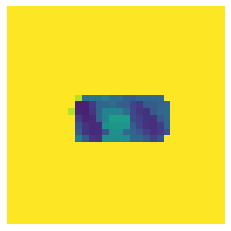

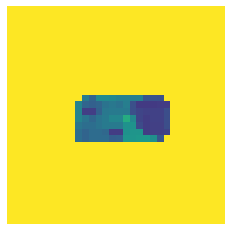

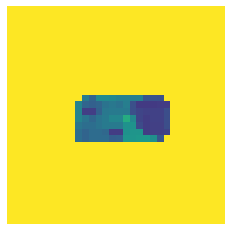

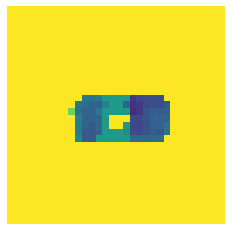

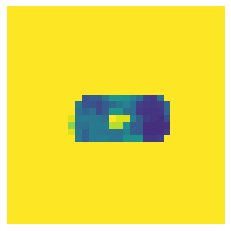

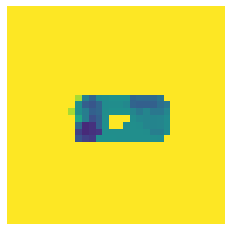

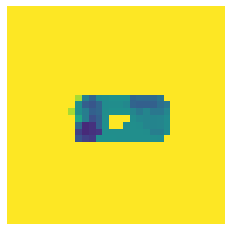

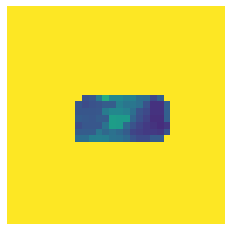

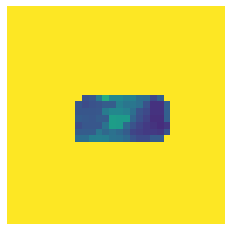

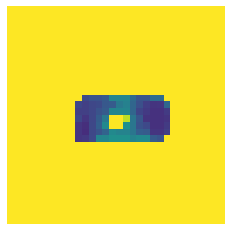

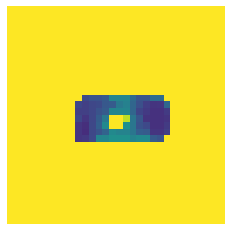

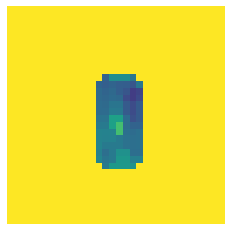

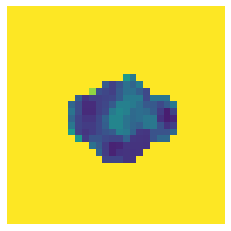

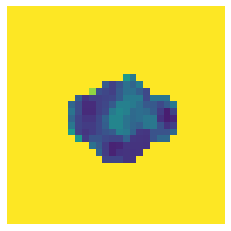

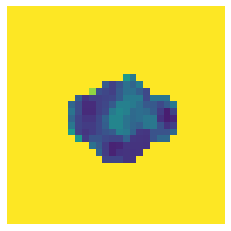

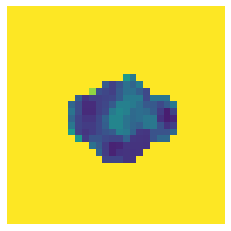

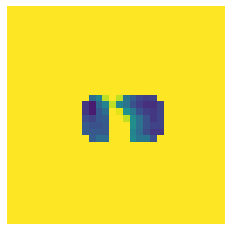

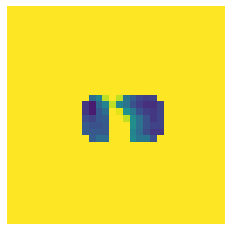

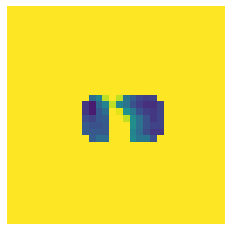

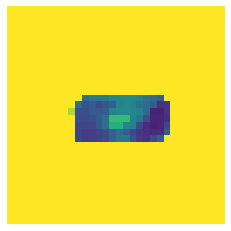

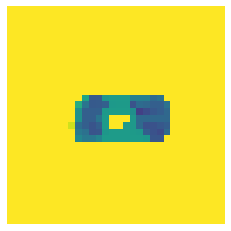

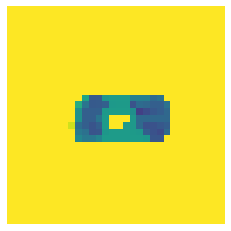

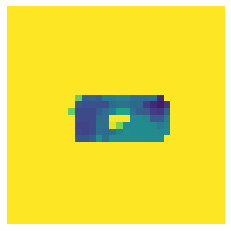

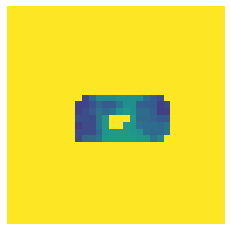

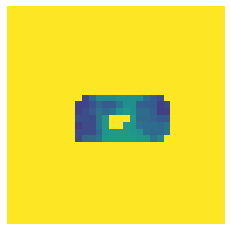

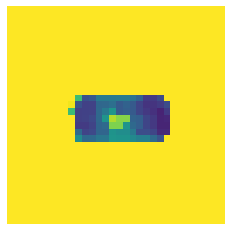

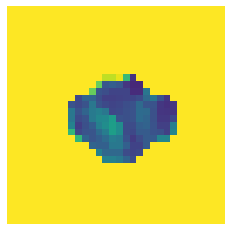

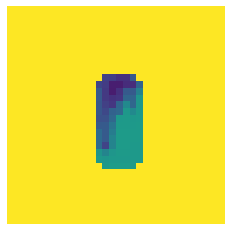

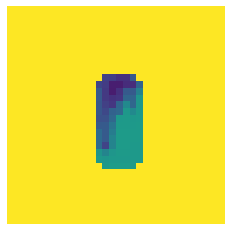

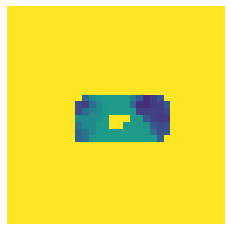

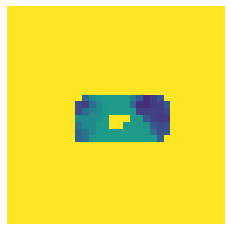

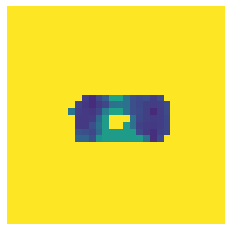

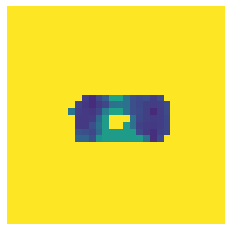

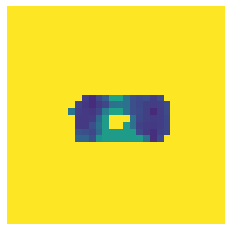

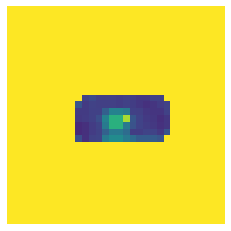

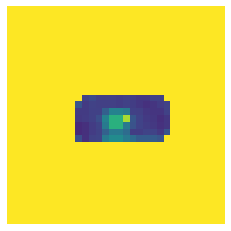

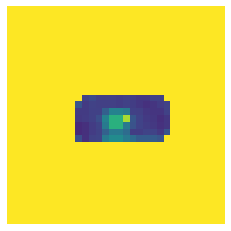

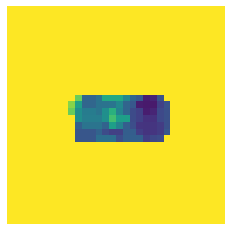

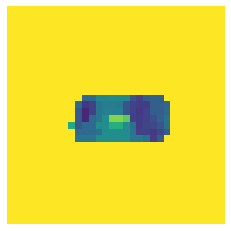

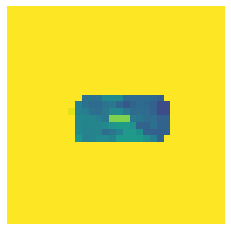

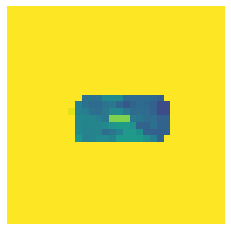

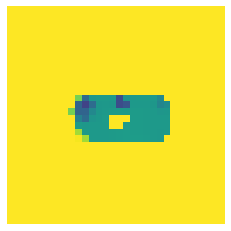

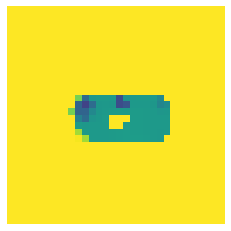

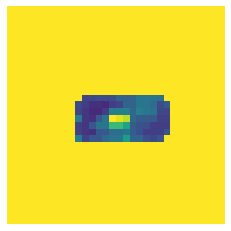

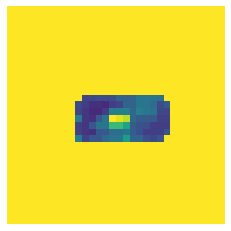

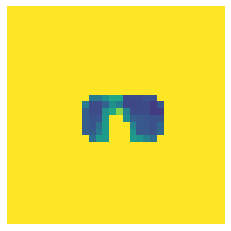

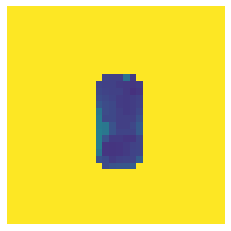

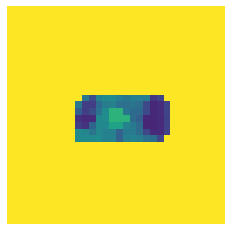

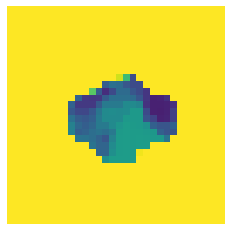

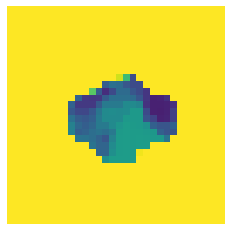

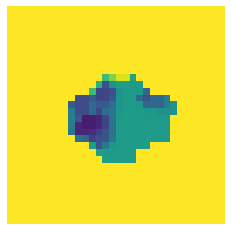

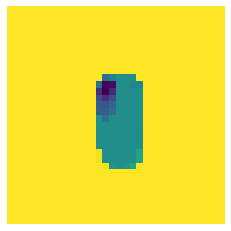

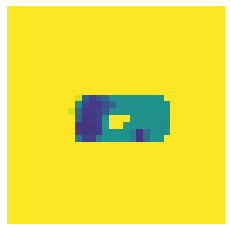

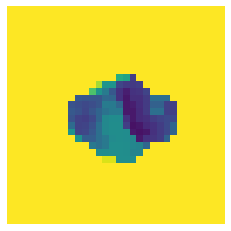

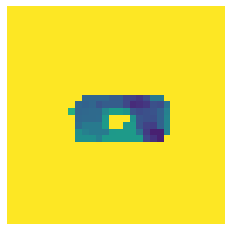

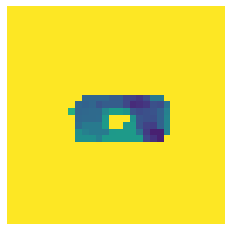

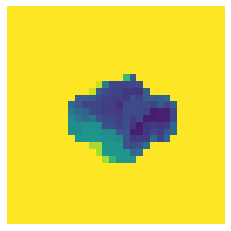

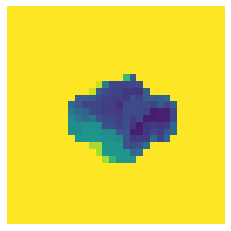

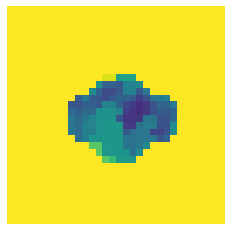

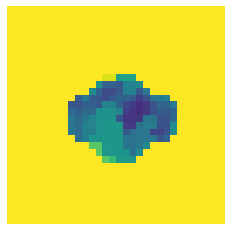

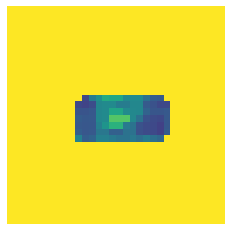

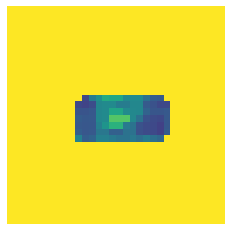

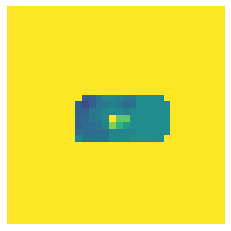

In [35]:
test_images = X_sick[split_idx_sick:]
# test_images.extend(X_normal[100:200])
test_labels = [1] * len(test_images)
# test_labels.extend([0] * len(X_normal[100:200]))
patientIds = df[df['class'] == 'Lung Opacity']['patientId'].values[split_idx_sick:]

results = []

test_imgset = ImageSet(test_images, test_labels, do_resize=False)
test_loader = DataLoader(dataset=test_imgset, batch_size=1, shuffle=False)

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader)):
        #load data
        patientId = patientIds[i]
        img_bb = draw(parsed[patientId]["dicom"], parsed[patientId]["boxes"], plot=False)
        input_img, label = data
        if device_ids:
            input_img = input_img.cuda(device_ids[0])
        c_label = label.numpy()
        
        output, *_ = net(input_img)
        out = output.cpu().numpy().argmax(-1)[0]
        results.append(out)
#         pred_class = categories_train[out]
#         print('\nImage {} classified as {}'.format(img_name,pred_class))
        #localize occluder
        score, occ_maps, part_scores = net.get_occlusion(input_img, label)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='',cbarmax=0, show=True)
        # concatenate original image and occluder map
        img_orig = np.array(img_bb)
        faco = img_orig.shape[0] / occ_img.shape[0]
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        out_name = f'results/rsna/without_occluder/{patientId}_with_occlusion_map.png'
        canvas = np.concatenate((img_bb, occ_img_s), axis=1)
        cv2.imwrite(out_name, canvas)
print(f'Accuracy: {accuracy_score(test_labels, results)}')

# With Occluder in Training

In [62]:
split_idx_normal = int(len(X_normal) * 0.80)
split_idx_sick = int(len(X_sick) * 0.80)

## Training

In [63]:
X_train = X_normal[:split_idx_normal]
X_train.extend(X_sick[:split_idx_sick])

y_train = [0] * len(X_normal[:split_idx_normal])
y_train.extend([1] * len(X_sick[:split_idx_sick]))

X_train, y_train = shuffle(X_train, y_train, random_state=42)

print('Total images for training ' + str(len(X_train)))
train_imageset = ImageSet(X_train, y_train)

Total images for training 160


In [64]:
%%time
net = init_model(bool_load_pretrained_model=False,occ_types=['general', 'pneumonia'])
net = train(net, train_imageset, epochs=5, bool_train_with_occluders=True)

Training
Epochs: [1/5], Train Acc:0.5, Train Loss:-51.282098388671876
Epochs: [2/5], Train Acc:0.63125, Train Loss:-55.069921875
Epochs: [3/5], Train Acc:0.65, Train Loss:-55.907379150390625
Epochs: [4/5], Train Acc:0.69375, Train Loss:-56.29820556640625
Epochs: [5/5], Train Acc:0.68125, Train Loss:-56.53701171875
CPU times: user 1min 13s, sys: 29.3 s, total: 1min 42s
Wall time: 1min 43s


## Testing

In [ ]:
test_images = X_sick[split_idx_sick:]
test_images.extend(X_normal[split_idx_normal:])
test_masks = [[]] * len(test_images)
test_labels = [1] * len(X_sick[split_idx_sick:])
test_labels.extend([0] * len(X_normal[split_idx_normal:]))

# test_images, test_labels = shuffle(test_images, test_labels, random_state=42)
test_imgset = ImageSet(test_images, test_labels)
test_loader = DataLoader(dataset=test_imgset, batch_size=1, shuffle=False)

patientIds = df[df['class'] == 'Normal']['patientId'].values[split_idx_normal:]
patientIds = np.concatenate((patientIds, 
                             df[df['class'] == 'Lung Opacity']['patientId'].values[split_idx_sick:]))
results = []

with torch.no_grad():
    for i, data in tqdm_notebook(enumerate(test_loader)):
        #load data
        patientId = patientIds[i]
        img_bb = draw(parsed[patientId]["dicom"], parsed[patientId]["boxes"], plot=False)
        input_img, label = data
        if device_ids:
            input_img = input_img.cuda(device_ids[0])
        c_label = label.numpy()
        
        output, *_ = net(input_img)
        out = output.cpu().numpy().argmax(-1)[0]
        results.append(out)
#         pred_class = categories_train[out]
#         print('\nImage {} classified as {}'.format(img_name,pred_class))
        #localize occluder
        score, occ_maps, part_scores = net.get_occlusion(input_img, label)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='',cbarmax=0, show=False)
        # concatenate original image and occluder map
        img_orig = np.array(img_bb)
        faco = img_orig.shape[0] / occ_img.shape[0]
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        out_name = f'results/rsna/with_occluder/{patientId}_with_occlusion_map.png'
        canvas = np.concatenate((img_bb, occ_img_s), axis=1)
        cv2.imwrite(out_name, canvas)
print(f'Accuracy: {accuracy_score(test_labels, results)}')

Examples of boxes

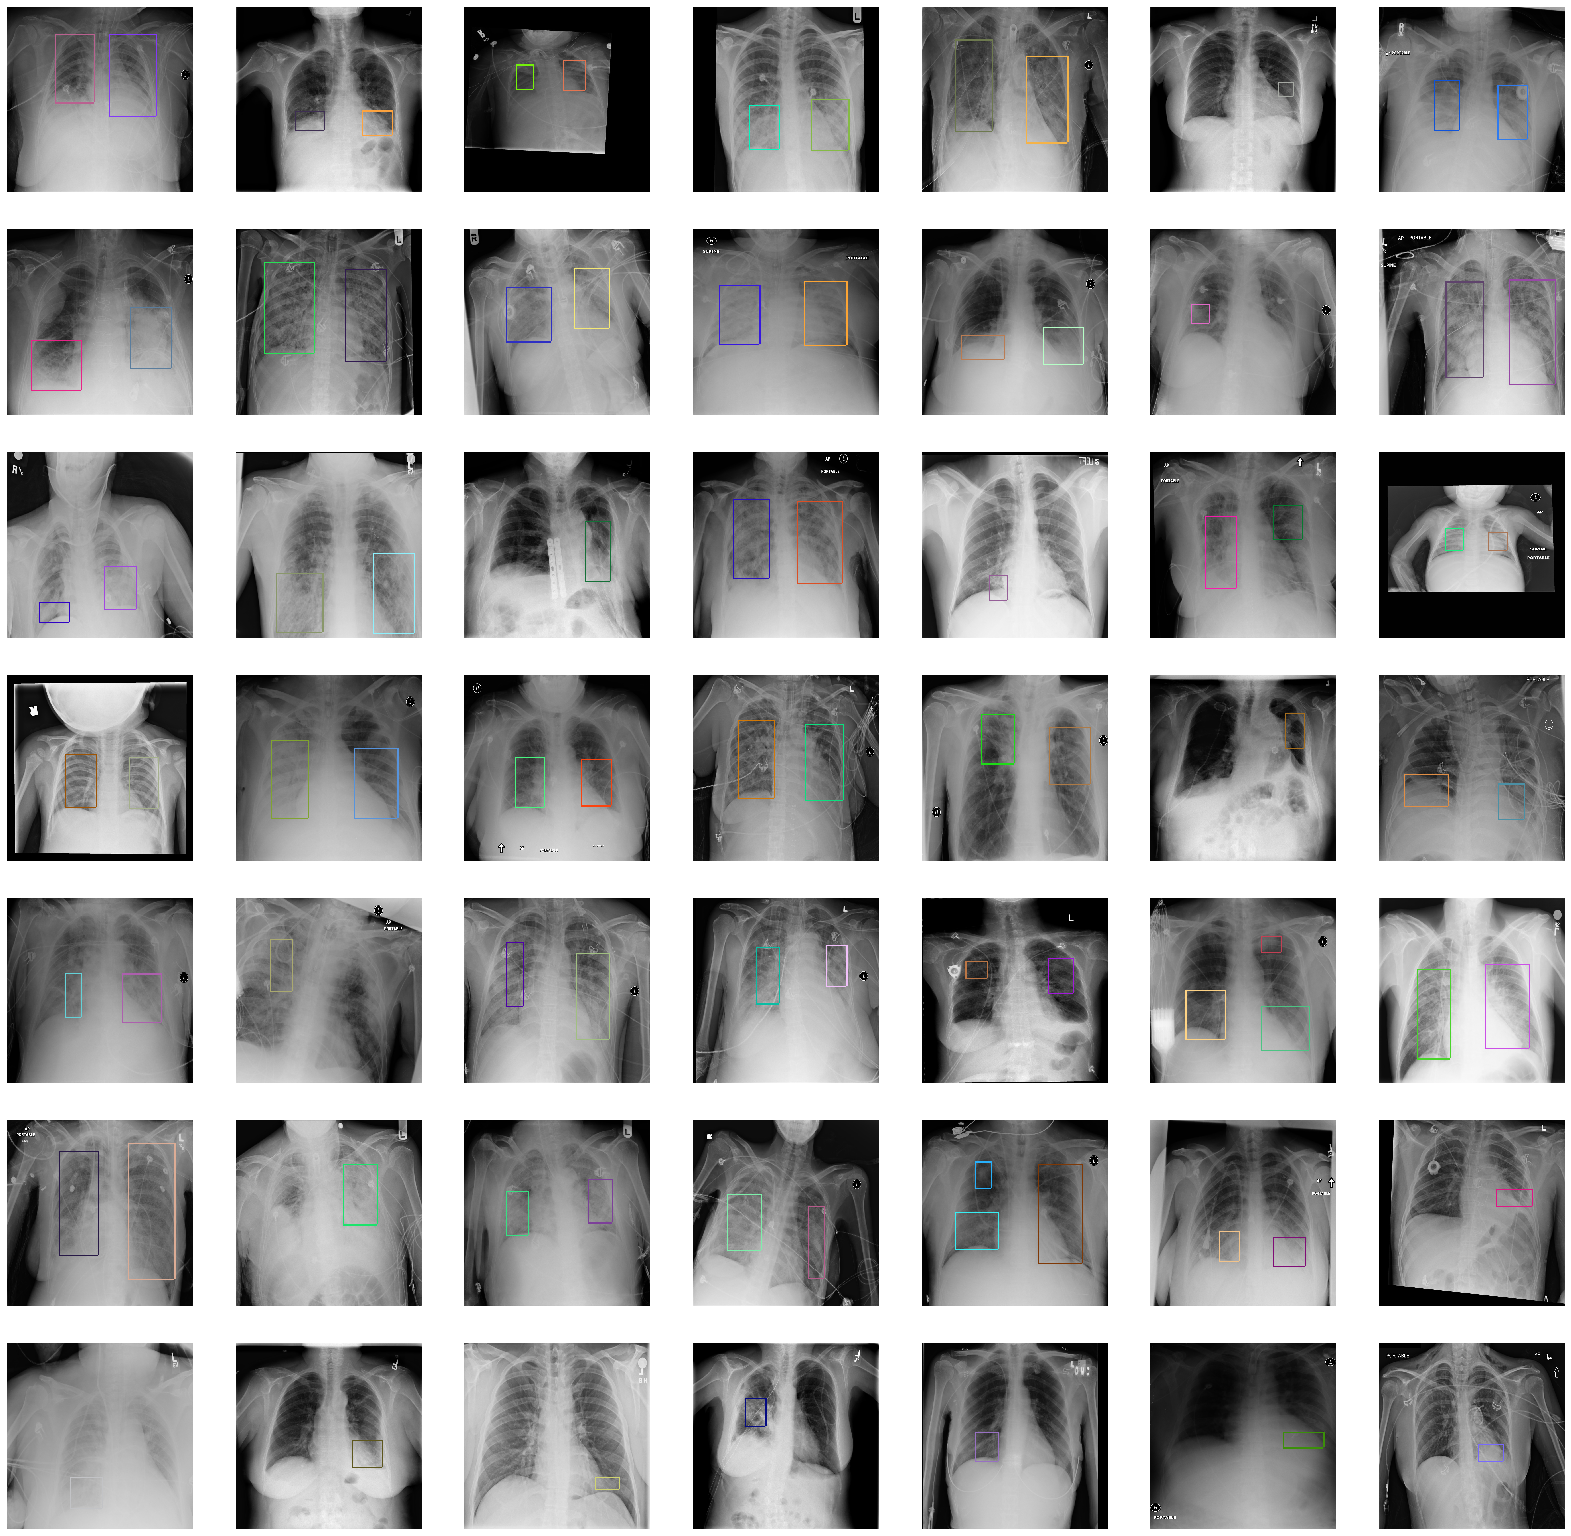

In [25]:
sick = [{k: v} for k, v in parsed.items() if v["label"] == 1]
rows, cols, i = 7, 7, 0
fig, axis = plt.subplots(rows, cols, figsize=(28,28), frameon=False)
for row in range(rows):
    for col in range(cols):
        values = list(sick[i].values())[0]
        im_bb = draw(values["dicom"], values["boxes"])
        axis[row, col].imshow(im_bb)
        axis[row, col].axis("off")
        i += 1